In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import os
import random

In [150]:
import pandas as pd
import numpy as np
import os
from sklearn.utils import shuffle
import sklearn 
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [154]:
# Training and Testing

def experiment(dataframe, path, svm_c = 1, svm_gamma = 'auto', plot = True):
    C = dataframe
    Test_accuracy = []
    Test_F1 = []
    Train_accuracy = []
    Train_F1 = []
    AUC = []

    FPR = []
    TPR = []
    THRESH = []

    for i in tqdm(range(0,10)):
        Train_dataframe = pd.DataFrame()
        Test_dataframe = pd.DataFrame()
        Train = np.loadtxt(f"./before_on_after_Vice_versa/{path}/Train/Train_{str(i)}.txt", 'str')
        Test = np.loadtxt(f"./before_on_after_Vice_versa/{path}/Test/Test_{str(i)}.txt", 'str')

        for j in range(0,len(Train)):
            Train_dataframe = Train_dataframe.append(C[C.iloc[:,73] == Train[j]])

        for j in range(0,len(Test)):
            Test_dataframe = Test_dataframe.append(C[C.iloc[:,73] == Test[j]]) 


        Train_dataframe = shuffle(Train_dataframe, random_state= 42)

        scaler = StandardScaler()
        scaler.fit(C.iloc[:,:72])

        X_train = pd.DataFrame(scaler.transform(Train_dataframe.iloc[:,:72]))
        y_train = Train_dataframe.iloc[:,72]
        X_test = pd.DataFrame(scaler.transform(Test_dataframe.iloc[:,:72]))
        y_test = Test_dataframe.iloc[:,72]

        X_train.reset_index(drop=True, inplace= True)
        X_test.reset_index(drop=True, inplace= True)
        y_train.reset_index(drop=True, inplace= True)
        y_test.reset_index(drop=True, inplace= True)


        model = svm.SVC(C = svm_c,gamma=svm_gamma, probability=True)
        model.fit(X_train,y_train)

        Train_accuracy.append(metrics.accuracy_score(y_train, model.predict(X_train)))
        Test_accuracy.append(metrics.accuracy_score(y_test, model.predict(X_test)))

        Train_F1.append(metrics.f1_score(y_train, model.predict(X_train)))
        Test_F1.append(metrics.f1_score(y_test, model.predict(X_test))) 

        pred_prob = model.predict_proba(X_test)
        fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)
        auc_score = roc_auc_score(y_test, pred_prob[:,1])
        FPR.append(fpr)
        TPR.append(tpr)
        THRESH.append(thresh)
        AUC.append(auc_score)

    if plot == True:
        plt.style.use('seaborn')
        color = ['orange', 'green', 'yellow', 'black', 'red', 'purple', 'pink', 'brown', 'magenta', 'grey']
        for i in range(0, len(AUC)):
            plt.plot(FPR[i], TPR[i], linestyle='--',color=color[i], label=f'model_{str(i)}_AUC:{AUC[i]}')

        random_probs = [0 for i in range(len(y_test))]
        p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
        plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
        plt.title('ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive rate')
        plt.legend(loc='best')
#         plt.savefig('ROC_Before_After_classification_'+path,dpi=300)
        plt.show();

        print(f"Mean Test Accuracy:{np.mean(Test_accuracy)*100}% with SD: {np.std(Test_accuracy)*100}%")
        print(f"Mean Train Accuracy:{np.mean(Train_accuracy)*100}%")
        print(f"Mean Test F1:{np.mean(Test_F1)*100}% with SD: {np.std(Test_F1)*100}%")
        print(f"Mean Test AUC:{np.mean(AUC)*100}% with SD: {np.std(AUC)*100}%")        
        
    return Train_accuracy, Test_accuracy, FPR, TPR, THRESH, AUC, Test_F1

In [2]:
data = pd.read_csv("./breath_csv_2/Breath.csv")

In [8]:
Total = np.unique(data.iloc[:,73])
name = []
for i in Total:
    name.append(i[:4])
unique = []
before_after = []
for i in Total:
    if np.sum((np.array(name, dtype = int) == int(i[:4]))) == 1:
        unique.append(i)
    else:
        before_after.append(i) 

Asthmatic_Female = []
Asthmatic_Male = []
Healthy_Male = []
Healthy_Female = []
NAsthma = []
before = {"male" : [], "female" : []}
after = {"male" : [], "female" : []}
for file in unique:
    if file.split("_")[2] == 'Asthma' or file.split("_")[2] == 'asthma' :
        if file.find("_M_")!=-1:
            Asthmatic_Male.append(file)
        if file.find("_F_")!=-1:
            Asthmatic_Female.append(file)
    if file.split("_")[2] == 'NAsthma':
        NAsthma.append(file)
    if file.find("_C_")!=-1:
        if file.find("_M_")!=-1:
            Healthy_Male.append(file)
        if file.find("_F_")!=-1:
            Healthy_Female.append(file)
            
for file in before_after:
        if file.find("efore") != -1:
            if file.find("_M_") != -1 or file.find("_m_")!=-1:
                before["male"].append(file)
            if file.find("_F_")!=-1:
                before["female"].append(file)
        if file.find("fter")!= -1:
            if file.find("_M_") != -1 or file.find("_m_")!=-1:
                after["male"].append(file)
            if file.find("_F_")!=-1:
                after["female"].append(file)

In [9]:
print(f"Total = {len(Total)}")
print(f"Asthmatic_male = {len(Asthmatic_Male)+ len(before['male'])+len(after['male'])}")
print(f"Asthmatic_female = {len(Asthmatic_Female)+ len(before['female'])+len(after['female'])}")
print(f"Healthy_Male = {len(Healthy_Male)}")
print(f"Healthy_female = {len(Healthy_Female)}")
print(f"Asthmatic_male_unique = {len(Asthmatic_Male)}")
print(f"Asthmatic_female_unique = {len(Asthmatic_Female)}")
print(f"Before_after = {len(before_after)}")
print(f"Before_male = {len(before['male'])}")
print(f"Before_female = {len(before['female'])}")
print(f"after_male = {len(after['male'])}")
print(f"after_female = {len(after['female'])}")

print(f"NAsthma = {len(NAsthma)}")

Total = 274
Asthmatic_male = 90
Asthmatic_female = 68
Healthy_Male = 55
Healthy_female = 51
Asthmatic_male_unique = 46
Asthmatic_female_unique = 28
Before_after = 84
Before_male = 22
Before_female = 20
after_male = 22
after_female = 20
NAsthma = 10


## Before, tested on After

In [35]:
name_male = []
name_female = []
for i in before['male']:
        name_male.append(i[:4])
for i in before['female']:
        name_female.append(i[:4])

### Experiment 1

In [116]:
for j in range(0,10):
    r = np.random.choice(name_male, 11, replace = False )
    bef_m = [i for i in Asthmatic_Male if i.find('before') != - 1]
    for i in before['male']:
        if np.sum((np.array(r, dtype = int) == int(i[:4]))) == 1:
            bef_m.append(i)
    af_m = [i for i in Asthmatic_Male if i.find('fter') != - 1]
    for i in after['male']:
        if np.sum((np.array(r, dtype = int) == int(i[:4]))) == 1:
            af_m.append(i)

    r = np.random.choice(name_female, 10, replace = False )
    bef_f = [i for i in Asthmatic_Female if i.find('efore') != - 1]
    for i in before['female']:
        if np.sum((np.array(r, dtype = int) == int(i[:4]))) == 1:
            bef_f.append(i)
    af_f = [i for i in Asthmatic_Female if i.find('fter') != - 1]
    for i in after['female']:
        if np.sum((np.array(r, dtype = int) == int(i[:4]))) == 1:
            af_f.append(i)
            
    test_set = np.concatenate(((np.random.choice(np.array(af_m), replace=False, size=(7)),
                                np.random.choice(np.array(af_f), replace=False, size=(7)),
                                np.random.choice(np.array(Healthy_Male), replace=False, size=(7)),
                                np.random.choice(np.array(Healthy_Female), replace=False, size=(7)))))
    train_set = np.concatenate((np.array(bef_m),
                                    np.array(bef_f),
                                    np.array(Healthy_Male),
                                    np.array(Healthy_Female)))
    train_set = np.setdiff1d(train_set,test_set)
    
    np.savetxt(f"./before_on_after_Vice_versa/Experiment_1/Sets/Train/Train_{j}.txt",train_set, '%s')
    np.savetxt(f"./before_on_after_Vice_versa/Experiment_1/Sets/Test/Test_{j}.txt",test_set, '%s')

In [112]:
print(f"Train Set size: {len(train_set)}")
print(f"Test Set size: {len(test_set)}")
print(f"Asthmatic in train Set: {len(bef_m) + len(bef_f)}")
print(f"Asthmatic male before Train Set size: {len(bef_m)}")
print(f"Asthmatic female before Train Set size: {len(bef_f)}")
print(f"Healthy in Train Set size: {len(Healthy_Male) - 7 + len(Healthy_Female) - 7}")

print(f"Healthy Male in Train Set size: {len(Healthy_Male) - 7}")
print(f"Healthy female in Train Set size: {len(Healthy_Female) - 7}")

Train Set size: 132
Test Set size: 28
Asthmatic in train Set: 40
Asthmatic male before Train Set size: 23
Asthmatic female before Train Set size: 17
Healthy in Train Set size: 92
Healthy Male in Train Set size: 48
Healthy female in Train Set size: 44


  0%|          | 0/10 [00:00<?, ?it/s]

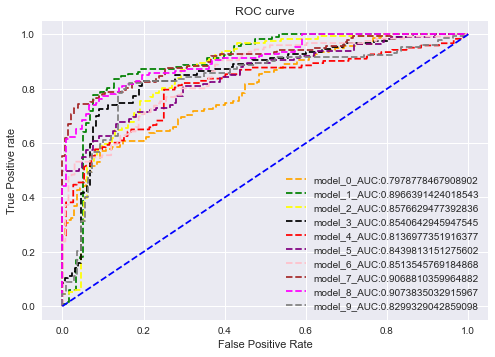

Mean Test Accuracy:76.31493500240624% with SD: 4.846941148103994%
Mean Train Accuracy:96.51163429001608%
Mean Test F1:71.21890523339746% with SD: 8.055382090079002%
Mean Test AUC:85.59475302338463% with SD: 3.591706763059084%


In [155]:
Train_accuracy, Test_accuracy, FPR, TPR, THRESH, AUC, Test_F1 = experiment(shuffle(data),'Experiment_1/Sets')

### Experiment 2: Removing imbalance from Train set

In [122]:
for j in range(0,10):
    r = np.random.choice(name_male, 11, replace = False )
    bef_m = [i for i in Asthmatic_Male if i.find('before') != - 1]
    for i in before['male']:
        if np.sum((np.array(r, dtype = int) == int(i[:4]))) == 1:
            bef_m.append(i)
    af_m = [i for i in Asthmatic_Male if i.find('fter') != - 1]
    for i in after['male']:
        if np.sum((np.array(r, dtype = int) == int(i[:4]))) == 1:
            af_m.append(i)

    r = np.random.choice(name_female, 10, replace = False )
    bef_f = [i for i in Asthmatic_Female if i.find('efore') != - 1]
    for i in before['female']:
        if np.sum((np.array(r, dtype = int) == int(i[:4]))) == 1:
            bef_f.append(i)
    af_f = [i for i in Asthmatic_Female if i.find('fter') != - 1]
    for i in after['female']:
        if np.sum((np.array(r, dtype = int) == int(i[:4]))) == 1:
            af_f.append(i)
    h_m = np.random.choice(np.array(Healthy_Male), replace=False, size=(7))
    h_f = np.random.choice(np.array(Healthy_Female), replace=False, size=(7))
    test_set = np.concatenate(((np.random.choice(np.array(af_m), replace=False, size=(7)),
                                np.random.choice(np.array(af_f), replace=False, size=(7)),
                                h_m,
                                h_f)))
    train_set = np.concatenate((np.array(bef_m),
                                    np.array(bef_f),
                                    np.random.choice((np.setdiff1d(Healthy_Male,h_m)), replace=False, size=(20)),
                                    np.random.choice((np.setdiff1d(Healthy_Female,h_f)), replace=False, size=(20))))
    train_set = np.setdiff1d(train_set,test_set)
    
    np.savetxt(f"./before_on_after_Vice_versa/Experiment_2/Sets/Train/Train_{j}.txt",train_set, '%s')
    np.savetxt(f"./before_on_after_Vice_versa/Experiment_2/Sets/Test/Test_{j}.txt",test_set, '%s')

In [127]:
print(f"Train Set size: {len(train_set)}")
print(f"Test Set size: {len(test_set)}")
print(f"Asthmatic in train Set: {len(bef_m) + len(bef_f)}")
print(f"Asthmatic male before Train Set size: {len(bef_m)}")
print(f"Asthmatic female before Train Set size: {len(bef_f)}")
print(f"Healthy in Train Set size: {len(np.random.choice((np.setdiff1d(Healthy_Male,h_m)), replace=False, size=(20)))+ len(np.random.choice((np.setdiff1d(Healthy_Female,h_f)), replace=False, size=(20))) }")

print(f"Healthy Male in Train Set size: {len(np.random.choice((np.setdiff1d(Healthy_Male,h_m)), replace=False, size=(20)))}")
print(f"Healthy female in Train Set size: {len(np.random.choice((np.setdiff1d(Healthy_Female,h_f)), replace=False, size=(20)))}")

Train Set size: 80
Test Set size: 28
Asthmatic in train Set: 40
Asthmatic male before Train Set size: 23
Asthmatic female before Train Set size: 17
Healthy in Train Set size: 40
Healthy Male in Train Set size: 20
Healthy female in Train Set size: 20


  0%|          | 0/10 [00:00<?, ?it/s]

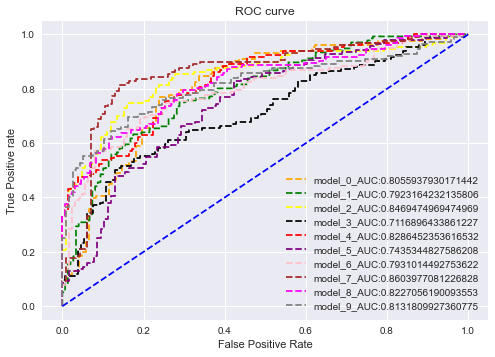

Mean Test Accuracy:73.81025395748698% with SD: 4.3968134974404744%
Mean Train Accuracy:97.24226635359697%
Mean Test F1:73.41393079668406% with SD: 4.9186810974142245%
Mean Test AUC:80.18112843828095% with SD: 4.29580817952146%


In [158]:
Train_accuracy, Test_accuracy, FPR, TPR, THRESH, AUC, Test_F1 = experiment(shuffle(data),'Experiment_2/Sets')

### Experiment 3

In [133]:
for j in range(0,10):
    r = np.random.choice(name_male, 11, replace = False )
    bef_m = [i for i in Asthmatic_Male if i.find('before') != - 1]
    for i in before['male']:
        if np.sum((np.array(r, dtype = int) == int(i[:4]))) == 1:
            bef_m.append(i)
    af_m = [i for i in Asthmatic_Male if i.find('fter') != - 1]
    for i in after['male']:
        if np.sum((np.array(r, dtype = int) == int(i[:4]))) == 1:
            af_m.append(i)

    r = np.random.choice(name_female, 10, replace = False )
    bef_f = [i for i in Asthmatic_Female if i.find('efore') != - 1]
    for i in before['female']:
        if np.sum((np.array(r, dtype = int) == int(i[:4]))) == 1:
            bef_f.append(i)
    af_f = [i for i in Asthmatic_Female if i.find('fter') != - 1]
    for i in after['female']:
        if np.sum((np.array(r, dtype = int) == int(i[:4]))) == 1:
            af_f.append(i)
            
    test_set = np.concatenate(((np.random.choice(np.array(bef_m), replace=False, size=(7)),
                                np.random.choice(np.array(bef_f), replace=False, size=(7)),
                                np.random.choice(np.array(Healthy_Male), replace=False, size=(7)),
                                np.random.choice(np.array(Healthy_Female), replace=False, size=(7)))))
    train_set = np.concatenate((np.array(af_m),
                                    np.array(af_f),
                                    np.array(Healthy_Male),
                                    np.array(Healthy_Female)))
    train_set = np.setdiff1d(train_set,test_set)
    
    np.savetxt(f"./before_on_after_Vice_versa/Experiment_3/Sets/Train/Train_{j}.txt",train_set, '%s')
    np.savetxt(f"./before_on_after_Vice_versa/Experiment_3/Sets/Test/Test_{j}.txt",test_set, '%s')

In [136]:
print(f"Train Set size: {len(train_set)}")
print(f"Test Set size: {len(test_set)}")
print(f"Asthmatic in train Set: {len(af_m) + len(af_f)}")
print(f"Asthmatic male before Train Set size: {len(af_m)}")
print(f"Asthmatic female before Train Set size: {len(af_f)}")
print(f"Healthy in Train Set size: {len(Healthy_Male) - 7 + len(Healthy_Female) - 7}")

print(f"Healthy Male in Train Set size: {len(Healthy_Male) - 7}")
print(f"Healthy female in Train Set size: {len(Healthy_Female) - 7}")

Train Set size: 168
Test Set size: 28
Asthmatic in train Set: 76
Asthmatic male before Train Set size: 45
Asthmatic female before Train Set size: 31
Healthy in Train Set size: 92
Healthy Male in Train Set size: 48
Healthy female in Train Set size: 44


  0%|          | 0/10 [00:00<?, ?it/s]

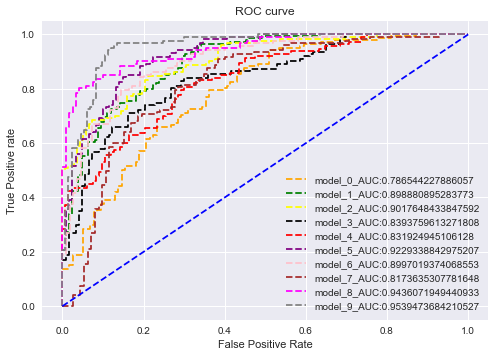

Mean Test Accuracy:78.63822560577871% with SD: 5.549042321678386%
Mean Train Accuracy:96.59928963898328%
Mean Test F1:79.34355224874886% with SD: 5.381852841384952%
Mean Test AUC:87.96044788835584% with SD: 5.403058169905851%


In [159]:
Train_accuracy, Test_accuracy, FPR, TPR, THRESH, AUC, Test_F1 = experiment(shuffle(data),'Experiment_3/Sets')

### Experiment 4

In [145]:
for j in range(0,10):
    r = np.random.choice(name_male, 11, replace = False )
    bef_m = [i for i in Asthmatic_Male if i.find('before') != - 1]
    for i in before['male']:
        if np.sum((np.array(r, dtype = int) == int(i[:4]))) == 1:
            bef_m.append(i)
    af_m = [i for i in Asthmatic_Male if i.find('fter') != - 1]
    for i in after['male']:
        if np.sum((np.array(r, dtype = int) == int(i[:4]))) == 1:
            af_m.append(i)

    r = np.random.choice(name_female, 10, replace = False )
    bef_f = [i for i in Asthmatic_Female if i.find('efore') != - 1]
    for i in before['female']:
        if np.sum((np.array(r, dtype = int) == int(i[:4]))) == 1:
            bef_f.append(i)
    af_f = [i for i in Asthmatic_Female if i.find('fter') != - 1]
    for i in after['female']:
        if np.sum((np.array(r, dtype = int) == int(i[:4]))) == 1:
            af_f.append(i)
    h_m = np.random.choice(np.array(Healthy_Male), replace=False, size=(7))
    h_f = np.random.choice(np.array(Healthy_Female), replace=False, size=(7))
    test_set = np.concatenate(((np.random.choice(np.array(bef_m), replace=False, size=(7)),
                                np.random.choice(np.array(bef_m), replace=False, size=(7)),
                                h_m,
                                h_f)))
    train_set = np.concatenate((np.array(af_m),
                                    np.array(af_f),
                                    np.random.choice((np.setdiff1d(Healthy_Male,h_m)), replace=False, size=(40)),
                                    np.random.choice((np.setdiff1d(Healthy_Female,h_f)), replace=False, size=(40))))
    train_set = np.setdiff1d(train_set,test_set)
    
    np.savetxt(f"./before_on_after_Vice_versa/Experiment_4/Sets/Train/Train_{j}.txt",train_set, '%s')
    np.savetxt(f"./before_on_after_Vice_versa/Experiment_4/Sets/Test/Test_{j}.txt",test_set, '%s')

In [146]:
print(f"Train Set size: {len(train_set)}")
print(f"Test Set size: {len(test_set)}")
print(f"Asthmatic in train Set: {len(af_m) + len(af_f)}")
print(f"Asthmatic male before Train Set size: {len(af_m)}")
print(f"Asthmatic female before Train Set size: {len(af_f)}")
print(f"Healthy in Train Set size: {len(np.random.choice((np.setdiff1d(Healthy_Male,h_m)), replace=False, size=(20)))+ len(np.random.choice((np.setdiff1d(Healthy_Female,h_f)), replace=False, size=(20))) }")

print(f"Healthy Male in Train Set size: {len(np.random.choice((np.setdiff1d(Healthy_Male,h_m)), replace=False, size=(40)))}")
print(f"Healthy female in Train Set size: {len(np.random.choice((np.setdiff1d(Healthy_Female,h_f)), replace=False, size=(40)))}")

Train Set size: 156
Test Set size: 28
Asthmatic in train Set: 76
Asthmatic male before Train Set size: 45
Asthmatic female before Train Set size: 31
Healthy in Train Set size: 40
Healthy Male in Train Set size: 40
Healthy female in Train Set size: 40


  0%|          | 0/10 [00:00<?, ?it/s]

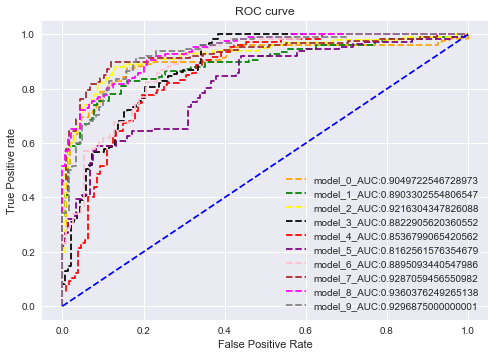

Mean Test Accuracy:78.56590075607095% with SD: 4.062598791507727%
Mean Train Accuracy:96.58674973251985%
Mean Test F1:79.55837932478346% with SD: 5.666464160130244%
Mean Test AUC:89.53099985786149% with SD: 3.5989569990200665%


In [161]:
Train_accuracy, Test_accuracy, FPR, TPR, THRESH, AUC, Test_F1 = experiment(shuffle(data),'Experiment_4/Sets')